In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

sns.set(style="white")

In [2]:
data_source_dir = r"K:\Projects\sarawak_energy\data"
output_source_dir = r"K:\Projects\sarawak_energy\output"
plot_dir = r"K:\Projects\sarawak_energy\plots"

In [3]:
def GetFile(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [4]:
xls = pd.ExcelFile(GetFile("sarawak_energy.xlsx"))

In [5]:
xls.sheet_names

['Consumption_Point_Data_Package',
 'parameters',
 'Occurrencies_Data_Package',
 'Billing_Data_Package']

In [6]:
df_dict = {}
for sheet_name in xls.sheet_names:
    df_dict[sheet_name] = xls.parse(sheet_name)

In [7]:
class LazyDict(dict):
    def keylist(self, keys, value):
        for key in keys:
            self[key] = value
    
    @staticmethod
    def add_to_dict(comps_list):
        for comps in comps_list:
            try:
                component_dict.keylist(comps[0], comps[1])
            except:
                print(comps)

In [8]:
comps_list = [
    # prioritize components
    [['illegal', 'tampering', 'teampering'], 'illegal and tampering'],
    [['inspect','insp', 'inspection','inpection','check', 'checking', 'checked'], 'inspection'],
    [['disconnect','disconnected', 'disconnection'], 'disconnect'], 
    [['read', 'reading'], 'reading'],
    [['arrears'], 'arrears'],
    [['displ', 'display'], 'no display'],
    [['change', 'replac', 'replace', 'replaced', 'replacement', 'replacment'], 'changing'],
    [['faulty'], 'faulty'],
    [['install', 'installation','new move in'], 'installing'],
    [['jammed'], 'jamming'],
    [['operation', 'opps', 'ops'], 'operating'],
    [[ 'replac', 'replace', 'replaced', 'replacement', 'replacment'], 'replacing'],
    [['reconnect', 'reconnection'], 'reconnecting'],
    [[ 'retest', 'retesting', 'test', 'testing'], 'testing'],
    [['upgrade', 'upgrading'], 'upgrading'],
    [['missing'], 'missing']
    
]

In [9]:
component_dict = LazyDict()
component_dict.add_to_dict(comps_list)

In [10]:
def add_component(description, component_dict):
    for comp in component_dict:
        if comp in description:
            return component_dict[comp]

    return "other"

In [11]:
def cleanse_df_cp(df_cp):
    
    non_null_cols = df_cp.isna().all()[df_cp.isna().all()==False].index.tolist()
    df_cp = df_cp[non_null_cols]
    df_cp.drop(["MoveIn", "MoveOut", "billing_factor"], inplace=True, axis = 1)
    
    df_cp["was_fraud"] = df_cp["was_fraud"].replace("S", 1)
    df_cp["was_fraud"] = df_cp["was_fraud"].replace(np.nan, 0)
    df_cp["was_fraud"] = df_cp["was_fraud"].astype(int)
    
    df_cp.rename(columns={'id':'id_uc'}, inplace=True)
    
    return df_cp

In [12]:
def spell_correct(description):
    
    description = description.lower()
    
    # remove numbers and special characters
    description = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', description)
    #description = TextBlob(description)
    #description = str(description.correct())
    
    return description

In [13]:
def cleanse_df_op(df_op):
    
    non_null_cols = df_op.isna().all()[df_op.isna().all()==False].index.tolist()

    df_op = df_op[non_null_cols]
    
    df_op["Desc"] = df_op["Desc"].apply(spell_correct)
    
    df_op["activity"] = df_op["Desc"].apply(add_component, component_dict=component_dict)
    
    return df_op

In [14]:
def cleanse_df_bp(df_bp):
    
    non_null_cols = df_bp.isna().all()[df_bp.isna().all()==False].index.tolist()

    df_bp = df_bp[non_null_cols]
    
    # replacing the nans with zeros
    df_bp.replace(np.nan, 0.0, inplace=True)
    
    return df_bp

In [15]:
def cleanse_df(df_dict):
    
    df_cp = cleanse_df_cp(df_dict['Consumption_Point_Data_Package'])
    
    df_op = cleanse_df_op(df_dict['Occurrencies_Data_Package'])
    
    df_bp = cleanse_df_bp(df_dict['Billing_Data_Package'])
    
    months_count =df_bp.groupby(['id_uc']).count()['date_reference'].reset_index()
    customers_filtered = list(months_count.query('date_reference >= 6')['id_uc'].unique())
    df_cp_filtered = df_cp[df_cp["id_uc"].isin(customers_filtered)]
    df_op_filtered = df_op[df_op["id_uc"].isin(customers_filtered)]
    df_bp_filtered = df_bp[df_bp["id_uc"].isin(customers_filtered)]
    
    return df_cp, df_op, df_bp

# Feature Engineering

There are mainly two types of features we can use which are the **Time Series Features** and the **Categorical Features**

## Time Series Features

Explained below

## Categorical Features

Number of checkings, etc..

## Pilot

* column for negative values
* remove negative values
* data normalization using min max scaler per customer
* Remove rows with less than 6 months data
* Dump it onto tsfresh first

## Features

### Paper 1
* Average consumption of last x months
* Maximum consumption of last x months
* Stdev consumption of last x months
* Number of inspection remarks last x months or suspect tampering
* Average consumption of residential area

### Paper 2
* Abrupt decrease in consumption
* Long period of low consumption compared to average
* Consumption discrepancy
* Consumption peak - Consumption in a month x% times higher/lower than
the previous and the following month.
* Billing/consumption similarity - (only in gas)
* Unknown consumption - Number of consecutive estimated readings, consecutive 0 or NULL consumption (in the present and historically)
* Negative Consumption - Whether the customer has a negative consumption (e.g. count was reset at the installation of a new meter)
* Reading correction, reset, or suspected tampering

# Further filtering

Filter out the following:

## Customers with less than 6 points of data
* 5% of customers removed
* 2 fraud customers were removed, remaining is 48
* 16 non-fraud customers were removed, 285 remaining

# Feasibility test

## Further issues with time series
* Discontinuous time series (not continuous)
* NULL values
* Multiple readings in a month
* Negative meter reading - meter reset
* Zero value - estimated reading
* How to compare with average ? - local ? set fixed time points ?
* Missing months in between

## ToDo

* Solve time series problems of discontinuity 
* Groupby resample mean
* Compute new set of features 
* Remember to compute using **% percentage drop** as need to normalize
* Consider normalizing data (global or local)

* Compute long time series from average
* Think of ways to capture the drops 

In [16]:
import datetime

In [17]:
def last_day(d):
    
    last = datetime.date(d.year + d.month // 12, d.month % 12 + 1, 1) - datetime.timedelta(1)
    return pd.to_datetime(last)
    

In [18]:
df_cp_filtered, df_op_filtered, df_bp_filtered = cleanse_df(df_dict)

k:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
k:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
k:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

# Time Series Features

* Format date to last day of month
* Resample time series by monthly mean
* Replace the NaNs as 0

In [19]:
y = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

df_bp_ts = df_bp_filtered.sort_values(['id_uc', 'date_reference']).drop(['date_measured', 'ReadType'], axis=1)

assert (len(y) == len(df_bp_ts['id_uc'].unique())), print("unique elements do not match")

In [20]:
df_bp_ts['date_reference'] = df_bp_ts['date_reference'].apply(last_day)

In [21]:
df_bp_ts.reset_index(drop=True, inplace=True)

df_bp_ts = df_bp_ts.groupby('id_uc').resample('M', on="date_reference").mean()
df_bp_ts = df_bp_ts.drop(['id_uc'], axis=1).reset_index()

df_bp_ts = df_bp_ts.replace(np.NaN, 0)

df_bp_ts.groupby('id_uc').size().sort_values().to_frame().merge(y, on='id_uc', how='inner').head()

In [25]:
df_bp_ts.head()

id_uc date_reference    Read  Billed  consumption_invoiced  \
0  100000023146     2016-08-31     0.0     0.0                   0.0   
1  100000023146     2016-09-30     0.0     0.0                   0.0   
2  100000023146     2016-10-31  3009.0  3009.0                3009.0   
3  100000023146     2016-11-30  5015.0  5015.0                2006.0   
4  100000023146     2016-12-31  7021.0  7021.0                2006.0   

   consumption_measured  value_measured  
0                   0.0             0.0  
1                   0.0             0.0  
2                3009.0          3009.0  
3                2006.0          5015.0  
4                2006.0          7021.0

In [26]:
from itertools import groupby

def len_iter(items):
    return sum(1 for _ in items)

def consecutive_zero(data):
    x = list((len_iter(run) for val, run in groupby(data) if val==0))
    if len(x)==0: return 0 
    else: return max(x)
    
def consecutive_negative(data):
    x = list((len_iter(run) for val, run in groupby(data) if val<0))
    if len(x)==0: return 0 
    else: return max(x)
    
def consecutive_low(data):
    x = list((len_iter(run) for val, run in groupby(data) if val==True))
    if len(x)==0: return 0 
    else: return max(x)
    
def cleanse_ts(ts):
    
    try:
        ts = ts.mask(ts <= 0, np.nan).interpolate(limit_direction='both')
    except:
        return np.NaN

    return ts

def cleanse_ts_series(ts):
    
    try:
        ts = ts.mask(ts <= 0, np.nan).interpolate(limit_direction='both')
    except:
        return np.NaN

    return ts

def sharp_drops_count(ts, series=False):
    a = .7

    try:
        d = pd.Series(ts.values[1:] - ts.values[:-1], index=ts.index[:-1]).abs()
        r = d.rolling(3, min_periods=1, win_type='parzen').sum()
        n = r.max()
    except:
        return np.NaN
    
    if series:
        return (r > n* a)
    else:
        return sum(r > n * a)

def highest_con_dif(ts):
    
    try:
        hcd = abs(min(ts - ts.shift(-1) ) / np.mean(ts))
    
    except:
        return np.NaN
    
    return hcd

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [27]:
def ts_feature_engineering(df):
    """
    Function for feature engineering of time series. Those that involves counts are expressed in %
    """
    # number of records
    records = int(len(df))
    
    # negatives represent a meter was reset
    negatives = np.mean(df['consumption_measured'] < 0) 
    
    # number of zeros in the ts. Zeros represent unknown or estimated figure
    zeros = np.mean(df['consumption_measured'] == 0) 
    
    # consecutive zeros percentage in consumption measured, consecituve zeros / number of records
    #https://stackoverflow.com/questions/51605651/find-longest-run-of-consecutive-zeros-for-each-user-in-dataframe
    consecutive_zeros = consecutive_zero(df['consumption_measured']) / records
    
    # consumption measured != consumption billed and consumption measured is positive
    consumption_difference = sum(df[df['consumption_invoiced']!=df['consumption_measured']]['consumption_measured']>0) / records
    
    # features that needs a cleansed time series
    ts = cleanse_ts(df['consumption_measured'])
    
    # sharp drop count
    sdc = sharp_drops_count(ts) / records
    
    # number of low periods count
    lpc = consecutive_low( sharp_drops_count(ts, True)) / records
    # number of peaks
    
    
    # highest consecutive difference / average 
    hcd = highest_con_dif(ts)
    
    # vs average of region, locality, municipality
    # MAPE vs municipality
    ts_local = df.set_index('date_reference').apply(cleanse_ts)[['id_uc', 'consumption_measured']].reset_index().merge(locations, on='id_uc', how='left')
    ts_local = ts_local.merge(locations_ts['id_locality'], on=['id_locality', 'date_reference'])
    mapd_local = mean_absolute_percentage_error(ts_local['consumption_measured_x'], ts_local['consumption_measured_y'])
    
    series_dict = {'records':records ,'negatives':negatives, 'zeros':zeros, 
                   'consecutive_zeros': consecutive_zeros, 'consumption_difference': consumption_difference,
                   'sharp_drop': sdc, 'consecutive_low': lpc, 'highest_con_diff': hcd, 'mapd_local': mapd_local
                  
                  }
    
    
    return pd.Series(series_dict)

In [28]:
locations = df_cp_filtered[['id_uc', 'id_region','id_locality', 'id_municipality']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

main_ts = df_bp_ts[['id_uc', 'date_reference', 'consumption_measured']].set_index('date_reference').groupby('id_uc').apply(cleanse_ts).reset_index()

main_ts = main_ts.merge(locations, on='id_uc', how='left')

locations_ts = {}

for location in ['id_region', 'id_locality', 'id_municipality']:
    
    locations_ts[location] = main_ts[['date_reference', 'consumption_measured', 'id_region', 'id_locality', 'id_municipality']].groupby([location]).resample('M', on="date_reference").mean().drop(['id_region'], axis=1).reset_index()

In [29]:
df_bp_ts['id_uc_2'] = df_bp_ts['id_uc'].copy()

In [30]:
ts_features = df_bp_ts.groupby('id_uc_2').apply(ts_feature_engineering)
ts_features = ts_features.reset_index().rename(columns={'id_uc_2':'id_uc'})

In [31]:
ts_features['id_uc'] = ts_features['id_uc'].astype(str)

In [33]:
ts_features.head()

id_uc  records  negatives     zeros  consecutive_zeros  \
0  100000023146     26.0   0.038462  0.115385           0.076923   
1  100000106908     89.0   0.011236  0.022472           0.011236   
2  100000328929    183.0   0.016393  0.158470           0.005464   
3  100000420500      1.0   0.000000  1.000000           1.000000   
4  100000597035    129.0   0.000000  0.449612           0.224806   

   consumption_difference  sharp_drop  consecutive_low  highest_con_diff  \
0                0.000000    0.115385         0.038462          0.599139   
1                0.000000    0.044944         0.022472          0.837240   
2                0.005464    0.005464         0.005464          8.911044   
3                0.000000    0.000000         0.000000               NaN   
4                0.000000    0.007752         0.007752          2.042415   

   mapd_local  
0    2.482151  
1    3.285958  
2    1.298429  
3         NaN  
4    0.000000

# Categorical Features

* Convert the <span class="girk">categorical activity column into a count</span> column by casting

In [34]:
agg_cat = df_op_filtered.sort_values(['id_uc', 'date_created']).groupby(['id_uc', 'activity']).size().to_frame().reset_index()

In [35]:
agg_cat_size = df_op_filtered.sort_values(['id_uc', 'date_created']).groupby('id_uc').size().to_frame().reset_index()

In [36]:
agg_cat_size.rename(columns={0:'total activities'}, inplace=True)

In [37]:
agg_cat.rename(columns={0:"count"}, inplace=True)

In [38]:
agg_cat = agg_cat.pivot(index='id_uc', columns='activity', values='count').reset_index()

agg_cat.columns.name = None
agg_cat.rename(columns={'other':'other total activities'}, inplace=True)
agg_cat.replace(np.NaN, 0, inplace=True)

In [39]:
#agg_cat = agg_cat.merge(agg_cat_size, on='id_uc', how='inner')

In [40]:
agg_cat['id_uc'] = agg_cat['id_uc'].astype(str)

In [139]:
agg_cat

id_uc  arrears  changing  disconnect  faulty  \
0    100000023146      0.0       0.0         0.0     0.0   
1    100000106908      0.0       0.0         0.0     0.0   
2    100000328929      0.0       0.0         0.0     0.0   
3    100000420500      0.0       0.0         2.0     0.0   
4    100000597035      0.0       0.0         0.0     0.0   
..            ...      ...       ...         ...     ...   
308  401005754120      0.0       0.0         0.0     0.0   
309  401016009113      0.0       0.0         0.0     0.0   
310  401017049106      1.0       0.0         7.0     0.0   
311  401021326106      0.0       0.0         0.0     0.0   
312  401048279102      0.0       0.0         0.0     0.0   

     illegal and tampering  inspection  installing  jamming  missing  \
0                      0.0         2.0         2.0      0.0      0.0   
1                      0.0         0.0         0.0      0.0      0.0   
2                      0.0         0.0         0.0      0.0      1.0   
3                      0.0         0.0         0.0      0.0      0.0   
4                      0.0         1.0         0.0      0.0      0.0   
..                     ...         ...         ...      ...      ...   
308                    0.0         2.0         0.0      0.0      0.0   
309                    0.0         2.0         0.0      0.0      0.0   
310                    0.0         0.0         0.0      0.0      0.0   
311                    0.0         0.0         0.0      0.0      0.0   
312                    0.0         2.0         0.0      0.0      0.0   

     no display  operating  other total activities  reading  reconnecting  \
0           0.0        0.0                     0.0      0.0           0.0   
1           0.0        0.0                     2.0      0.0           0.0   
2           0.0        0.0                     0.0      1.0           0.0   
3           1.0        0.0                     1.0      0.0           1.0   
4           0.0        1.0                     8.0      0.0           0.0   
..          ...        ...                     ...      ...           ...   
308         0.0        3.0                     4.0      0.0           1.0   
309         0.0        1.0                     0.0      0.0           0.0   
310         0.0        2.0                     6.0      0.0           2.0   
311         0.0        1.0                     0.0      0.0           0.0   
312         0.0        1.0                     0.0      1.0           0.0   

     replacing  testing  upgrading  
0          0.0      1.0        0.0  
1          0.0      0.0        0.0  
2          0.0      0.0        0.0  
3          0.0      0.0        0.0  
4          0.0      0.0        0.0  
..         ...      ...        ...  
308        0.0      0.0        0.0  
309        0.0      0.0        0.0  
310        0.0      0.0        0.0  
311        0.0      0.0        0.0  
312        0.0      0.0        0.0  

[313 rows x 18 columns]

In [42]:
ts_features.shape

(350, 10)

# Merge both TS and Categorical count features

In [52]:
df = ts_features.merge(agg_cat, on="id_uc", how="left")

In [53]:
cat_features = ['arrears', 'changing', 'disconnect', 'faulty',
       'illegal and tampering', 'inspection', 'installing', 'jamming',
       'missing', 'no display', 'operating', 'other total activities', 'reading',
       'reconnecting', 'replacing', 'testing', 'upgrading']

In [54]:
# labels = df_cp_filtered[['id_uc', 'was_fraud', 'id_uc_aggregated_class', 'id_uc_class', 'id_uc_contract_situation',
#        'id_uc_meter_brand']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

labels = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

labels['id_uc'] = labels['id_uc'].astype(str)

#labels = pd.get_dummies(labels.set_index(['id_uc', 'was_fraud'])).reset_index()

In [55]:
df = df.merge(labels, on="id_uc", how="inner")

In [56]:
df[cat_features] = df[cat_features].replace(np.NaN, 0)

In [61]:
df.columns.tolist()

['id_uc',
 'records',
 'negatives',
 'zeros',
 'consecutive_zeros',
 'consumption_difference',
 'sharp_drop',
 'consecutive_low',
 'highest_con_diff',
 'mapd_local',
 'arrears',
 'changing',
 'disconnect',
 'faulty',
 'illegal and tampering',
 'inspection',
 'installing',
 'jamming',
 'missing',
 'no display',
 'operating',
 'other total activities',
 'reading',
 'reconnecting',
 'replacing',
 'testing',
 'upgrading',
 'was_fraud']

# XGBOOST

In [69]:
import xgboost as xgb
import shap
import matplotlib.pylab as pl
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, f1_score, precision_score, roc_curve, auc
from sklearn.metrics import recall_score, roc_auc_score, precision_recall_curve, confusion_matrix

In [70]:
shap.initjs()

In [62]:
#predictors = df.columns.tolist()

predictors = ['id_uc', 'records', 'negatives', 'zeros', 'consecutive_zeros', 'sharp_drop', 'consecutive_low',
       'highest_con_diff', 'mapd_local', 'was_fraud']

In [63]:
predictors.remove('id_uc')
predictors.remove('was_fraud')
#predictors.remove('other')

In [64]:
predictors

['records',
 'negatives',
 'zeros',
 'consecutive_zeros',
 'sharp_drop',
 'consecutive_low',
 'highest_con_diff',
 'mapd_local']

In [125]:
ids = df['id_uc']
X = df[['id_uc'] + predictors]
y = df['was_fraud']

In [126]:
sps = y.value_counts()[0]/y.value_counts()[1]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)
X_train_cp = X_train.copy()
X_test_cp = X_test.copy()
X_train.drop('id_uc', axis=1, inplace=True)
X_test.drop('id_uc', axis=1, inplace=True)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

#d_whole = xgb.DMatrix(X, label=y)

k:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [128]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "max_depth": 7,
    "eval_metric": "logloss",
    "scale_pos_weight": sps,
    "n_jobs": -1,
    "silent": 1,
    "seed": 2147
}
results = {}

model = xgb.train(params, d_train, 1000, evals = [(d_train, "train"), (d_test, "test")], verbose_eval=100, early_stopping_rounds=100, evals_result=results)

[0]	train-logloss:0.686561	test-logloss:0.688567
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.321673	test-logloss:0.441463
[200]	train-logloss:0.183435	test-logloss:0.360911
[300]	train-logloss:0.122748	test-logloss:0.327531
[400]	train-logloss:0.091055	test-logloss:0.315443
[500]	train-logloss:0.071302	test-logloss:0.310568
Stopping. Best iteration:
[498]	train-logloss:0.07164	test-logloss:0.310567



In [129]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.drop('id_uc', axis=1))

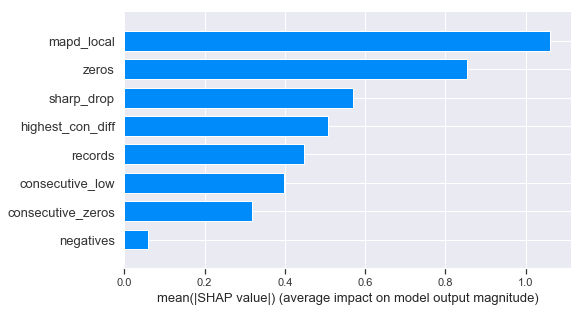

In [130]:
shap.summary_plot(shap_values, X.drop('id_uc', axis=1), plot_type="bar")


In [122]:
?shap.summary_plot

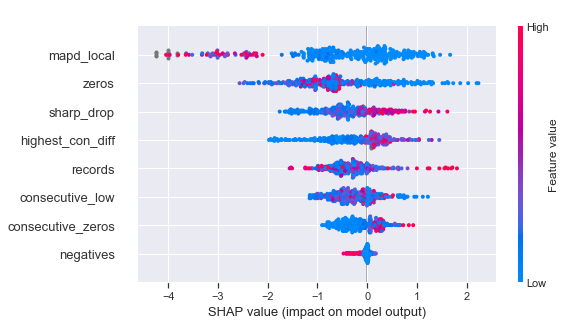

In [131]:
shap.summary_plot(shap_values, X.drop('id_uc', axis=1))


In [132]:
predictions_proba = model.predict(d_test) 
predictions = (model.predict(d_test) > 0.5).astype(int)

In [133]:
predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0])

In [134]:
true = np.array(y_test)

In [135]:
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        60
           1       0.75      0.60      0.67        10

   micro avg       0.91      0.91      0.91        70
   macro avg       0.84      0.78      0.81        70
weighted avg       0.91      0.91      0.91        70



In [136]:
print(f"F1-Score is {f1_score(true, predictions)}")
print(f"Precision is {precision_score(true, predictions)}")
print(f"Recall is {recall_score(true, predictions)}")
print(f"ROC AUC score is {roc_auc_score(true, predictions)}")

F1-Score is 0.6666666666666665
Precision is 0.75
Recall is 0.6
ROC AUC score is 0.7833333333333334


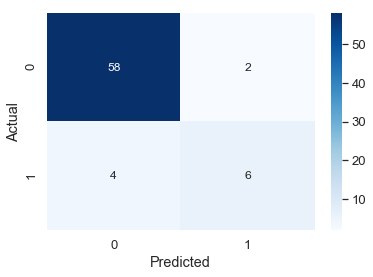

In [137]:
data = confusion_matrix(true, predictions)

df_cm = pd.DataFrame(data, columns=np.unique(true), index = np.unique(true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

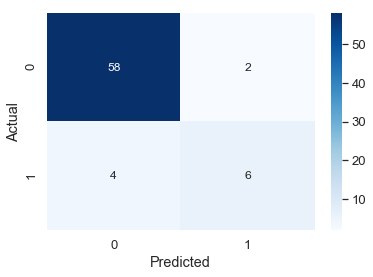

In [138]:
df_cm = pd.DataFrame(data, columns=np.unique(true), index = np.unique(true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

## Use SHAP to investigate the false negatives and true positives

In [83]:
summary_pred = pd.DataFrame()
summary_pred['true'] = true
summary_pred['prediction'] = predictions
summary_pred['predict_proba'] = predictions_proba

In [84]:
X_test_cp = X_test_cp.reset_index(drop=True)

In [85]:
X_test_cp['true'] = pd.Series(list(true))
X_test_cp['prediction'] = pd.Series(list(predictions))
X_test_cp['predict_proba'] = pd.Series(list(predictions_proba))


### List of false negatives

In [86]:
false_negatives = (X_test_cp['true']==1 ) & (X_test_cp['prediction']==0 )

false_negatives_list = list(X_test_cp[false_negatives]['id_uc'])

In [87]:
probas_list = list(X_test_cp[false_negatives]['predict_proba'])

In [88]:
probas_list

[0.09158477932214737,
 0.03332265838980675,
 0.06045364588499069,
 0.061932891607284546]

In [89]:
X[X['id_uc'].isin(false_negatives_list)]

id_uc  records  negatives     zeros  consecutive_zeros  \
108  100003441514     81.0   0.000000  0.086420           0.012346   
166  100004363638     11.0   0.000000  0.454545           0.363636   
176  100004532229     19.0   0.000000  0.052632           0.052632   
187  100004621524     34.0   0.058824  0.088235           0.058824   

     sharp_drop  consecutive_low  highest_con_diff  mapd_local  
108    0.049383         0.012346          0.555783    0.618600  
166    0.090909         0.090909          3.007309   18.488721  
176    0.052632         0.052632          2.111485    0.195766  
187    0.117647         0.058824          1.881065    0.000000

In [72]:
data_source_dir

'K:\\Projects\\sarawak_energy\\data'

In [73]:
i=108
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

In [74]:
i=176
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

In [75]:
i=187
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

# UPDATE SHAP to 0.31

## TODO

Come up with prediction probability to highlight very borderline effect

### List of false positives

In [76]:
false_positives = (X_test_cp['true']==0 ) & (X_test_cp['prediction']==1 )

false_positives_list = list(X_test_cp[false_positives]['id_uc'])

In [77]:
probas_list = list(X_test_cp[false_positives]['predict_proba'])

In [78]:
X_test_cp[false_positives]

id_uc  records  negatives     zeros  consecutive_zeros  \
18  100000597035    129.0        0.0  0.449612           0.224806   

    consumption_difference  sharp_drop  consecutive_low  highest_con_diff  \
18                     0.0    0.007752         0.007752          2.042415   

    mapd_local      ...        operating  other total activities  reading  \
18         0.0      ...              1.0                     8.0      0.0   

    reconnecting  replacing  testing  upgrading  true  prediction  \
18           0.0        0.0      0.0        0.0     0           1   

    predict_proba  
18       0.531271  

[1 rows x 30 columns]

In [79]:
probas_list

[0.5312706828117371]

In [80]:
sns.set_style('white')

In [81]:
i=4
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

## xgb.train cross validation

* Using xgb.train for cross validation

In [90]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from scipy import interp

ModuleNotFoundError: No module named 'imblearn'

In [91]:
X_imp = X.replace(np.NaN, 0)

In [92]:
params

{'eta': 0.01,
 'objective': 'binary:logistic',
 'max_depth': 7,
 'eval_metric': 'logloss',
 'scale_pos_weight': 6.142857142857143,
 'n_jobs': -1,
 'silent': 1,
 'seed': 2147}

In [96]:
xgb_results = {}

cv = StratifiedKFold(shuffle=True, random_state=2147, n_splits=5)

f1_scores_list = []
auc_scores_list = []
precision_scores_list = []


for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X_imp.iloc[train_idx], y[train_idx]
    X_test, y_test = X_imp.iloc[test_idx], y[test_idx]
    
    # Uncomment for using SMOTE
    #X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    #X_train = pd.DataFrame(X_train, columns = X.columns)
    #y_train = pd.Series(y_train)
    
    d_train = xgb.DMatrix(X_train.drop('id_uc', axis=1), label=y_train)
    d_test = xgb.DMatrix(X_test.drop('id_uc', axis=1), label=y_test)
    
    model_xgb = xgb.train(params, d_train, 1000, evals = [(d_train, "train"), (d_test, "test")], verbose_eval=0, early_stopping_rounds=100, evals_result=xgb_results)
    predictions = (model_xgb.predict(d_test) > 0.5).astype(int)
    true = np.array(y_test)
    
    
    
    f1_scores_list.append(f1_score(true, predictions))
    auc_scores_list.append(roc_auc_score(true, predictions))
    #print(f"F1-Score for fold {fold+1} is {f1_score(true, predictions)}")

In [99]:
f1_scores_list

[0.5,
 0.33333333333333326,
 0.2105263157894737,
 0.4000000000000001,
 0.26666666666666666]

In [108]:
auc_scores_list

[0.7090163934426229,
 0.6083333333333333,
 0.5416666666666666,
 0.65,
 0.5777777777777778]

In [100]:
print(f"Mean F1-Score is {np.mean(f1_scores_list)}")
print(f"Mean AUC is {np.mean(auc_scores_list)}")

Mean F1-Score is 0.34210526315789475
Mean AUC is 0.6173588342440801


In [107]:
f1_scores_list

[0.5,
 0.33333333333333326,
 0.2105263157894737,
 0.4000000000000001,
 0.26666666666666666]

## sklearn cross_val_predict
* Using xgb.XGBClassifier and sklearn cross_val_score
* Should produce similar results as above

In [101]:
params_2 = params.copy()

In [102]:
params_2.update({'n_estimators': 1000,
                'early_stopping_rounds': 100
                })

In [103]:
xgb_clf = xgb.XGBClassifier(**params_2)

In [104]:
f1_scores_full = cross_val_score(xgb_clf, X.drop(['id_uc'], axis=1), y, cv = StratifiedKFold(shuffle=True, random_state=2148, n_splits=5), scoring='f1',n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


In [105]:
auc_scores_full = cross_val_score(xgb_clf, X.drop(['id_uc'], axis=1), y, cv = StratifiedKFold(shuffle=True, random_state=2148, n_splits=5), scoring='roc_auc',n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


In [106]:
print(f"Avg F1-Score is: {np.mean(f1_scores_full)}")
print(f"Avg AUC is: {np.mean(auc_scores_full)}")

Avg F1-Score is: 0.2852790346907994
Avg AUC is: 0.702795385549484


# Data that could help improve the model

* Credit worthiness ranking of customer - payment performance, income, etc all in a single score
* Smart meter load profile of customer - enable changepoint detection
* More fraud data 
* Past fraud data

# Saving Prediction File

In [106]:
X.shapX_train.drop('id_uc', axis=1, inplace=True)
X_test.drop('id_uc', axis=1, inplace=True)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

(350, 27)

In [108]:
X_dmatrix = xgb.DMatrix(X.drop(['id_uc'], axis=1), label=y)

In [110]:
X_predict_proba = model.predict(X_dmatrix)

In [116]:
X_predictions = (X_predict_proba > 0.5).astype(int)

In [121]:
confusion_matrix(y, X_predictions)

array([[300,   1],
       [  3,  46]], dtype=int64)

In [123]:
X_output = X.copy(deep=True)

In [126]:
X_output['actual'] = y
X_output['predicted'] = X_predictions
X_output['predictions_proba'] = X_predict_proba

In [128]:
X_output.to_csv(r'K:\Projects\sarawak_energy\viz\cleansed_df_predictions.csv', index=False)